## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import create_aggregation_features
from src.features.interactions import create_interaction_features
from src.features.temporal import create_temporal_features
from src.features.missing_features import create_missing_value_features
from src.models.lgbm_baseline import LGBMBaseline
from src.models.hyperparameter_tuning import LGBMTuner, quick_tune, staged_tuning
from src.utils import (
    plot_roc_curve,
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Create All Features (Milestones 7-10)

In [4]:
# Create all features from previous milestones
print("Creating all features...\n")

# Missing value features
train_df, missing_feature_names = create_missing_value_features(train_df)
print(f"✓ Created {len(missing_feature_names)} missing value features")

# Aggregation features
train_df, agg_feature_names = create_aggregation_features(train_df, target_col='TransactionAmt')
print(f"✓ Created {len(agg_feature_names)} aggregation features")

# Interaction features
train_df, interaction_feature_names = create_interaction_features(train_df, min_samples=10)
print(f"✓ Created {len(interaction_feature_names)} interaction features")

# Temporal features (without velocity for speed)
train_df, temporal_feature_names = create_temporal_features(train_df, include_velocity=False)
print(f"✓ Created {len(temporal_feature_names)} temporal features")

print(f"\nFinal shape: {train_df.shape}")
print(f"Total engineered features: {len(missing_feature_names) + len(agg_feature_names) + len(interaction_feature_names) + len(temporal_feature_names)}")

Creating all features...


CREATING MISSING VALUE FEATURES

Creating basic missing value indicators...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Creating indicators for 322 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 20 group missing features
Creating missing value co-occurrence features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 12 co-occurrence features
Creating card-related missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
  Created 8 unusual pattern features
Creating missing value interaction features...
  Created 8 unusual pattern features
Creating

## 4. Prepare Data

In [5]:
# Prepare features
print("Preparing data for modeling...\n")

# Separate target
y = train_df['isFraud']
X = train_df.drop(['isFraud', 'TransactionID'], axis=1)

print(f"Starting features: {X.shape[1]}")

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

print("\nEncoding categorical features...")
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(categorical_features)} categorical features")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])

# Fill missing values
print("\nFilling missing values...")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\n✓ Final feature count: {X.shape[1]}")
print("✓ Data preparation complete")

Preparing data for modeling...

Starting features: 755

Encoding categorical features...
Starting features: 755

Encoding categorical features...
Found 59 categorical features
Found 59 categorical features

Filling missing values...

Filling missing values...

✓ Final feature count: 755
✓ Data preparation complete

✓ Final feature count: 755
✓ Data preparation complete


## 5. Train/Validation Split

In [6]:
# Time-based split
print("Creating time-based train/validation split...\n")

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_val = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_val = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]:,} samples, fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation set: {X_val.shape[0]:,} samples, fraud rate: {y_val.mean()*100:.2f}%")
print(f"Features: {X_train.shape[1]}")
print("\n✓ Data split complete")

Creating time-based train/validation split...

Training set: 472,432 samples, fraud rate: 3.51%
Validation set: 118,108 samples, fraud rate: 3.44%
Features: 755

✓ Data split complete


## 6. Baseline Model (Default Parameters)

In [7]:
# Train baseline model with default parameters from M10
print("Training baseline model with default parameters...\n")

baseline_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 256,
    'max_depth': 12,
    'min_child_samples': 50,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

baseline_model = LGBMBaseline(params=baseline_params)
baseline_metrics = baseline_model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

baseline_auc = baseline_metrics['val_auc']

print(f"\n{'='*70}")
print(f"BASELINE MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"Validation AUC: {baseline_auc:.6f}")
print(f"Training AUC: {baseline_metrics['train_auc']:.6f}")
print(f"{'='*70}")

Training baseline model with default parameters...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 755

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.988147	valid's auc: 0.976334
[100]	train's auc: 0.988147	valid's auc: 0.976334
[200]	train's auc: 0.992963	valid's auc: 0.979805
[200]	train's auc: 0.992963	valid's auc: 0.979805
[300]	train's auc: 0.995357	valid's auc: 0.981235
[300]	train's auc: 0.995357	valid's auc: 0.981235
[400]	train's auc: 0.996696	valid's auc: 0.982129
[400]	train's auc: 0.996696	valid's auc: 0.982129
[500]	train's auc: 0.99733	valid's auc: 0.982594
[500]	train's auc: 0.99733	valid's auc: 0.982594
[600]	train's auc: 0.997832	valid's auc: 0.982985
[600]	train's auc: 0.997832	valid's auc: 0.982985
[700]	train's auc: 0.99828	valid's auc: 0.983299

## 7. Quick Hyperparameter Tuning (50 trials)

In [8]:
# Quick tuning with Optuna - 50 trials (with parallel execution)
print("Running quick hyperparameter tuning (50 trials)...\n")
print("This may take 15-30 minutes depending on your hardware.\n")
print("Using parallel execution to leverage M3 Mac cores...\n")

# Create tuner
tuner_quick = LGBMTuner(
    X_train, y_train, 
    X_val, y_val,
    verbose=True
)

# Run tuning with parallel execution
# n_jobs parameter enables parallel trial execution
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create study with parallel-friendly sampler
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=10, multivariate=True)
)

# Run optimization with multiple parallel jobs
study.optimize(
    lambda trial: tuner_quick._objective(trial),
    n_trials=50,
    n_jobs=-1,  # Use all available cores (M3 Mac will use all performance cores)
    show_progress_bar=True
)

# Store results in tuner
tuner_quick.study = study
tuner_quick.best_params = study.best_params

# Get complete parameters
quick_best_params = tuner_quick.best_params
quick_complete_params = tuner_quick.get_best_params(include_fixed=True)

print(f"\n✓ Optimization complete! Best AUC: {study.best_value:.6f}")


Running quick hyperparameter tuning (50 trials)...

This may take 15-30 minutes depending on your hardware.

Using parallel execution to leverage M3 Mac cores...



Best trial: 37. Best value: 0.984438: 100%|██████████| 50/50 [1:35:00<00:00, 114.01s/it]  


✓ Optimization complete! Best AUC: 0.984438


In [9]:
# Visualize optimization history
print("\nOptimization History:\n")
try:
    tuner_quick.plot_optimization_history()
except:
    # Fallback if plotly not available
    import matplotlib.pyplot as plt
    trials_df = tuner_quick.study.trials_dataframe()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(trials_df['number'], trials_df['value'], marker='o', linewidth=1, markersize=4)
    ax.axhline(y=tuner_quick.study.best_value, color='r', linestyle='--', label=f'Best: {tuner_quick.study.best_value:.6f}')
    ax.set_xlabel('Trial Number', fontsize=12)
    ax.set_ylabel('ROC-AUC Score', fontsize=12)
    ax.set_title('Optimization History (Quick Tuning)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Optimization History:



In [10]:
# Visualize parameter importances
print("\nParameter Importances:\n")
try:
    tuner_quick.plot_param_importances()
except:
    # Fallback visualization
    from optuna.importance import get_param_importances
    
    importances = get_param_importances(tuner_quick.study)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    params = list(importances.keys())
    values = list(importances.values())
    
    ax.barh(params, values, color='skyblue', edgecolor='black')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title('Parameter Importances (Quick Tuning)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()


Parameter Importances:



## 8. Train Model with Quick-Tuned Parameters

In [11]:
# Train model with quick-tuned parameters
print("Training model with quick-tuned parameters...\n")

quick_tuned_model = LGBMBaseline(params=quick_complete_params)
quick_tuned_metrics = quick_tuned_model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

quick_tuned_auc = quick_tuned_metrics['val_auc']

print(f"\n{'='*70}")
print(f"QUICK-TUNED MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"Validation AUC: {quick_tuned_auc:.6f}")
print(f"Training AUC: {quick_tuned_metrics['train_auc']:.6f}")
print(f"Improvement over baseline: +{(quick_tuned_auc - baseline_auc):.6f}")
print(f"{'='*70}")

Training model with quick-tuned parameters...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 755

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.989406	valid's auc: 0.977236
[100]	train's auc: 0.989406	valid's auc: 0.977236
[200]	train's auc: 0.994283	valid's auc: 0.98064
[200]	train's auc: 0.994283	valid's auc: 0.98064
[300]	train's auc: 0.996545	valid's auc: 0.98202
[300]	train's auc: 0.996545	valid's auc: 0.98202
[400]	train's auc: 0.997815	valid's auc: 0.982963
[400]	train's auc: 0.997815	valid's auc: 0.982963
[500]	train's auc: 0.998441	valid's auc: 0.983401
[500]	train's auc: 0.998441	valid's auc: 0.983401
[600]	train's auc: 0.998891	valid's auc: 0.983716
[600]	train's auc: 0.998891	valid's auc: 0.983716
[700]	train's auc: 0.999248	valid's auc: 0.983928
[700]

## 9. Staged Hyperparameter Tuning (Advanced)

In [12]:
# Staged tuning - optimize in stages
print("Running staged hyperparameter tuning...\n")
print("This optimizes parameters in 3 stages: tree structure, sampling, regularization.\n")
print("This may take 30-45 minutes depending on your hardware.\n")

staged_best_params = staged_tuning(
    X_train, y_train,
    X_val, y_val,
    n_trials_per_stage=30,
    verbose=True
)

# Create complete parameter set
staged_complete_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'random_state': 42,
    'n_jobs': -1,
    'subsample_freq': 1,
}
staged_complete_params.update(staged_best_params)

Running staged hyperparameter tuning...

This optimizes parameters in 3 stages: tree structure, sampling, regularization.

This may take 30-45 minutes depending on your hardware.

STAGED HYPERPARAMETER TUNING

STAGE 1: Learning rate and tree structure


Best trial: 29. Best value: 0.984274: 100%|██████████| 30/30 [1:20:55<00:00, 161.85s/it]



Stage 1 Best AUC: 0.984274
  • learning_rate             0.013129
  • num_leaves                210
  • max_depth                 15
  • min_child_samples         29
  • subsample                 0.962221
  • colsample_bytree          0.534938
  • reg_alpha                 0.277925
  • reg_lambda                1.332351

STAGE 2: Sampling parameters


Best trial: 18. Best value: 0.984404: 100%|██████████| 30/30 [1:23:01<00:00, 166.06s/it]



Stage 2 Best AUC: 0.984404
  • subsample                 0.933343
  • colsample_bytree          0.855891
  • min_child_samples         25
  • learning_rate             0.023160
  • num_leaves                36
  • max_depth                 11
  • reg_alpha                 1.671123
  • reg_lambda                0.026352

STAGE 3: Regularization


Best trial: 17. Best value: 0.983764: 100%|██████████| 30/30 [50:35<00:00, 101.17s/it]


Stage 3 Best AUC: 0.983764
  • reg_alpha                 1.238117
  • reg_lambda                0.009734
  • learning_rate             0.037534
  • num_leaves                364
  • max_depth                 9
  • min_child_samples         40
  • subsample                 0.986986
  • colsample_bytree          0.631849

STAGED TUNING COMPLETE

Final Best AUC: 0.983764

Final parameters:
  • learning_rate             0.037534
  • num_leaves                364
  • max_depth                 9
  • min_child_samples         40
  • subsample                 0.986986
  • colsample_bytree          0.631849
  • reg_alpha                 1.238117
  • reg_lambda                0.009734


## 10. Train Model with Staged-Tuned Parameters

In [13]:
# Train model with staged-tuned parameters
print("Training model with staged-tuned parameters...\n")

staged_tuned_model = LGBMBaseline(params=staged_complete_params)
staged_tuned_metrics = staged_tuned_model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

staged_tuned_auc = staged_tuned_metrics['val_auc']

print(f"\n{'='*70}")
print(f"STAGED-TUNED MODEL PERFORMANCE")
print(f"{'='*70}")
print(f"Validation AUC: {staged_tuned_auc:.6f}")
print(f"Training AUC: {staged_tuned_metrics['train_auc']:.6f}")
print(f"Improvement over baseline: +{(staged_tuned_auc - baseline_auc):.6f}")
print(f"Improvement over quick: +{(staged_tuned_auc - quick_tuned_auc):.6f}")
print(f"{'='*70}")

Training model with staged-tuned parameters...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 755

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.993008	valid's auc: 0.98041
[100]	train's auc: 0.993008	valid's auc: 0.98041
[200]	train's auc: 0.995858	valid's auc: 0.982323
[200]	train's auc: 0.995858	valid's auc: 0.982323
[300]	train's auc: 0.997553	valid's auc: 0.983132
[300]	train's auc: 0.997553	valid's auc: 0.983132
[400]	train's auc: 0.998565	valid's auc: 0.983441
[400]	train's auc: 0.998565	valid's auc: 0.983441
[500]	train's auc: 0.999247	valid's auc: 0.983514
[500]	train's auc: 0.999247	valid's auc: 0.983514
[600]	train's auc: 0.999627	valid's auc: 0.983602
[600]	train's auc: 0.999627	valid's auc: 0.983602
Early stopping, best iteration is:
[583]	train's auc

## 11. Compare All Models

HYPERPARAMETER TUNING RESULTS

Baseline (default params):          0.984151
Quick tuning (50 trials):           0.984438  (+0.000286)
Staged tuning (90 trials):          0.983652  (+-0.000499)

Target (Top 10%):                   0.945000
Gap to target:                       -0.038652


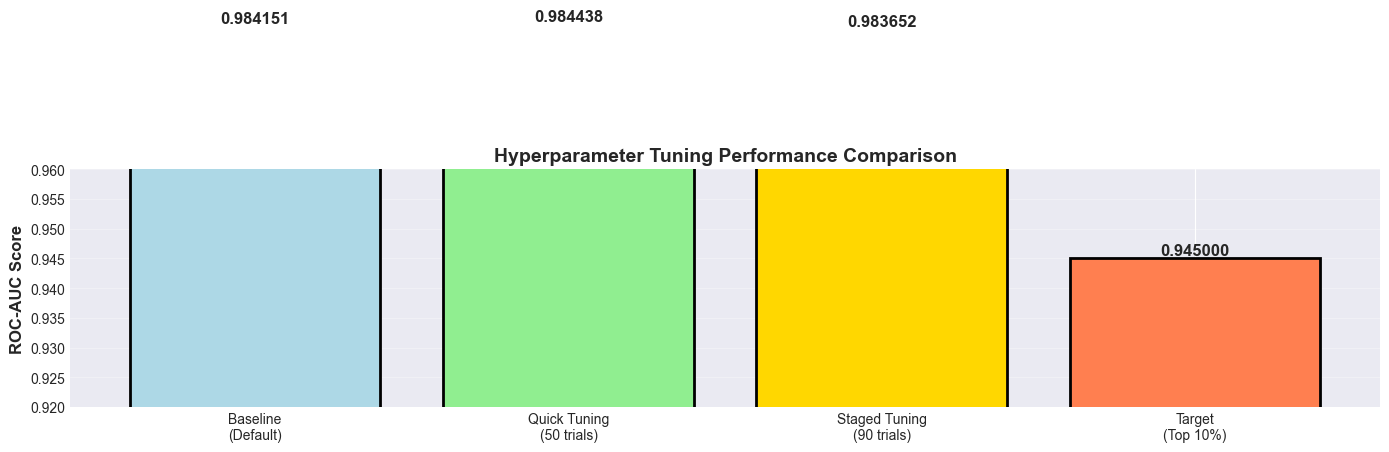

In [14]:
# Performance comparison
print("="*70)
print("HYPERPARAMETER TUNING RESULTS")
print("="*70)

print(f"\nBaseline (default params):          {baseline_auc:.6f}")
print(f"Quick tuning (50 trials):           {quick_tuned_auc:.6f}  (+{(quick_tuned_auc - baseline_auc):.6f})")
print(f"Staged tuning (90 trials):          {staged_tuned_auc:.6f}  (+{(staged_tuned_auc - baseline_auc):.6f})")

print(f"\nTarget (Top 10%):                   0.945000")
print(f"Gap to target:                       {(0.945 - staged_tuned_auc):.6f}")
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

models = ['Baseline\n(Default)', 'Quick Tuning\n(50 trials)', 'Staged Tuning\n(90 trials)', 'Target\n(Top 10%)']
scores = [baseline_auc, quick_tuned_auc, staged_tuned_auc, 0.945]
colors = ['lightblue', 'lightgreen', 'gold', 'coral']

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Hyperparameter Tuning Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0.92, 0.96)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 12. Parameter Comparison

In [15]:
# Compare parameters
param_comparison = pd.DataFrame({
    'Parameter': ['learning_rate', 'num_leaves', 'max_depth', 'min_child_samples', 
                  'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'],
    'Baseline': [
        baseline_params['learning_rate'],
        baseline_params['num_leaves'],
        baseline_params['max_depth'],
        baseline_params['min_child_samples'],
        baseline_params['subsample'],
        baseline_params['colsample_bytree'],
        baseline_params['reg_alpha'],
        baseline_params['reg_lambda']
    ],
    'Quick Tuned': [
        quick_complete_params['learning_rate'],
        quick_complete_params['num_leaves'],
        quick_complete_params['max_depth'],
        quick_complete_params['min_child_samples'],
        quick_complete_params['subsample'],
        quick_complete_params['colsample_bytree'],
        quick_complete_params['reg_alpha'],
        quick_complete_params['reg_lambda']
    ],
    'Staged Tuned': [
        staged_complete_params['learning_rate'],
        staged_complete_params['num_leaves'],
        staged_complete_params['max_depth'],
        staged_complete_params['min_child_samples'],
        staged_complete_params['subsample'],
        staged_complete_params['colsample_bytree'],
        staged_complete_params['reg_alpha'],
        staged_complete_params['reg_lambda']
    ]
})

print("\n" + "="*70)
print("PARAMETER COMPARISON")
print("="*70)
print(param_comparison.to_string(index=False))
print("="*70)


PARAMETER COMPARISON
        Parameter  Baseline  Quick Tuned  Staged Tuned
    learning_rate      0.01     0.010466      0.037534
       num_leaves    256.00   274.000000    364.000000
        max_depth     12.00    15.000000      9.000000
min_child_samples     50.00    28.000000     40.000000
        subsample      0.90     0.940653      0.986986
 colsample_bytree      0.70     0.860056      0.631849
        reg_alpha      0.50     0.740935      1.238117
       reg_lambda      0.50     0.585400      0.009734


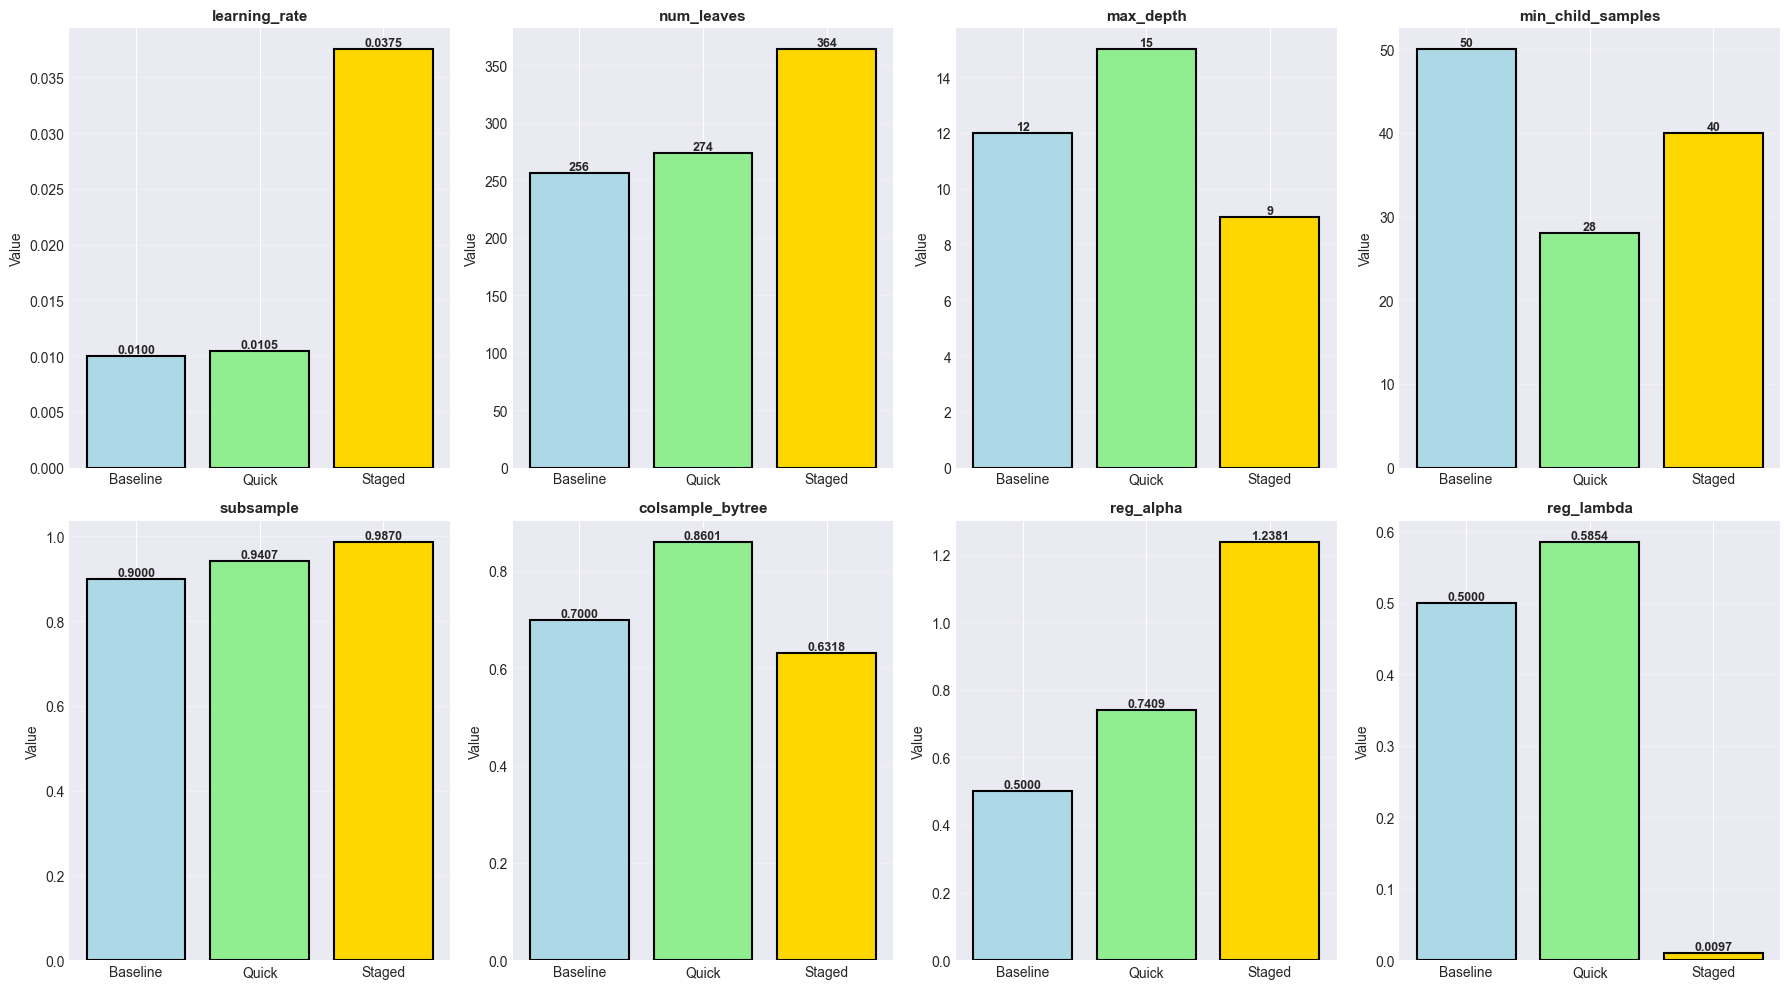

In [16]:
# Visualize parameter changes
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

params_to_plot = ['learning_rate', 'num_leaves', 'max_depth', 'min_child_samples', 
                  'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']

for idx, param in enumerate(params_to_plot):
    ax = axes[idx]
    
    values = [baseline_params[param], quick_complete_params[param], staged_complete_params[param]]
    labels = ['Baseline', 'Quick', 'Staged']
    colors_bar = ['lightblue', 'lightgreen', 'gold']
    
    bars = ax.bar(labels, values, color=colors_bar, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.4f}' if isinstance(value, float) else f'{value}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_title(param, fontsize=11, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 13. Feature Importance Comparison

In [17]:
# Compare feature importance between baseline and tuned
baseline_importance = baseline_model.get_feature_importance(top_n=20)
tuned_importance = staged_tuned_model.get_feature_importance(top_n=20)

print("Top 20 Features - Baseline vs Tuned:\n")
print("="*100)
print(f"{'Rank':<6} {'Feature (Baseline)':<45} {'Feature (Tuned)':<45}")
print("="*100)

for i in range(20):
    baseline_feat = baseline_importance.iloc[i]['feature'] if i < len(baseline_importance) else ''
    tuned_feat = tuned_importance.iloc[i]['feature'] if i < len(tuned_importance) else ''
    print(f"{i+1:<6} {baseline_feat:<45} {tuned_feat:<45}")

print("="*100)

Top 20 Features - Baseline vs Tuned:

Rank   Feature (Baseline)                            Feature (Tuned)                              
1      card1_addr1_ProductCD_fraud_rate              card1_addr1_ProductCD_fraud_rate             
2      card1_email_ProductCD_fraud_rate              card1_email_ProductCD_fraud_rate             
3      card1_addr1_fraud_rate                        C1                                           
4      C1                                            DeviceInfo_id_31_fraud_rate                  
5      DeviceInfo_id_31_fraud_rate                   card1_addr1_ProductCD_count                  
6      card1_addr1_ProductCD_count                   C14                                          
7      card1_P_emaildomain_fraud_rate                card1_R_emaildomain_fraud_rate               
8      C14                                           card1_P_emaildomain_fraud_rate               
9      card1_R_emaildomain_fraud_rate                card1_addr1_fraud_

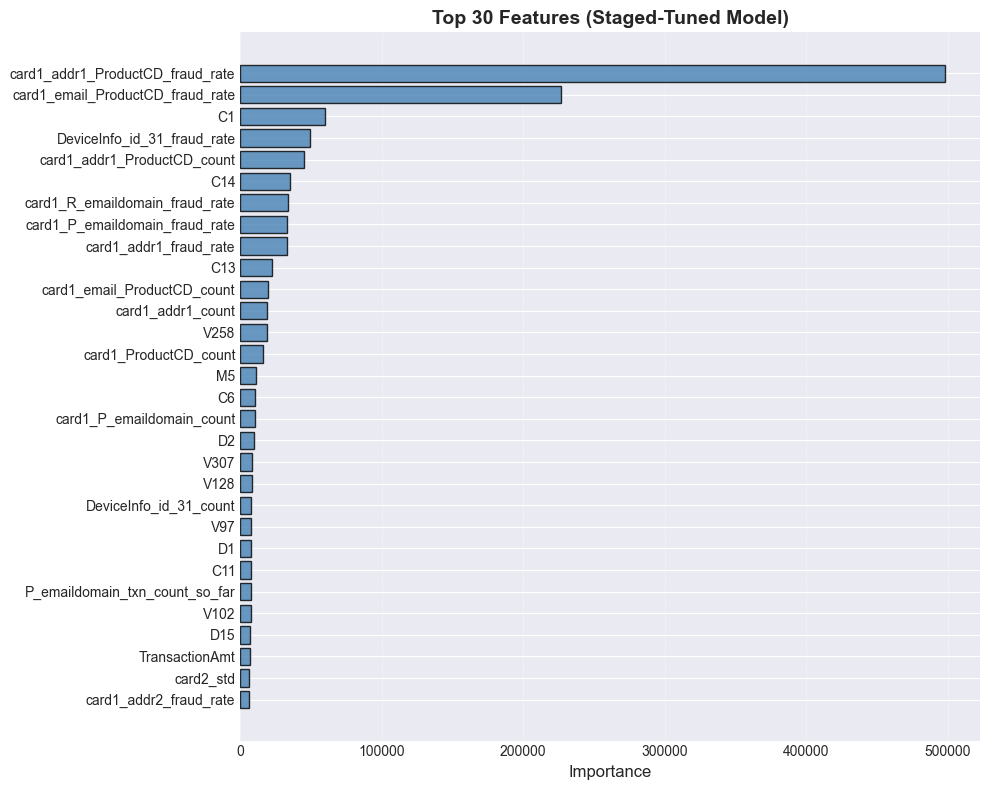

In [18]:
# Plot feature importance for tuned model
plot_feature_importance(
    staged_tuned_model.feature_importance,
    top_n=30,
    title="Top 30 Features (Staged-Tuned Model)"
)

## 14. Save Best Parameters

In [19]:
# Save best parameters to JSON
os.makedirs('../models', exist_ok=True)

# Save quick-tuned parameters
with open('../models/quick_tuned_params.json', 'w') as f:
    json.dump(quick_complete_params, f, indent=4)

# Save staged-tuned parameters
with open('../models/staged_tuned_params.json', 'w') as f:
    json.dump(staged_complete_params, f, indent=4)

# Save models
baseline_model.save_model('../models/lgbm_baseline_default.txt')
quick_tuned_model.save_model('../models/lgbm_quick_tuned.txt')
staged_tuned_model.save_model('../models/lgbm_staged_tuned.txt')

print("✓ Parameters and models saved successfully!")
print("\nSaved files:")
print("  • ../models/quick_tuned_params.json")
print("  • ../models/staged_tuned_params.json")
print("  • ../models/lgbm_baseline_default.txt")
print("  • ../models/lgbm_quick_tuned.txt")
print("  • ../models/lgbm_staged_tuned.txt")

✓ Model saved: ../models/lgbm_baseline_default.txt
✓ Metadata saved: ../models/lgbm_baseline_default_metadata.json
✓ Model saved: ../models/lgbm_quick_tuned.txt
✓ Metadata saved: ../models/lgbm_quick_tuned_metadata.json
✓ Model saved: ../models/lgbm_staged_tuned.txt
✓ Metadata saved: ../models/lgbm_staged_tuned_metadata.json
✓ Parameters and models saved successfully!

Saved files:
  • ../models/quick_tuned_params.json
  • ../models/staged_tuned_params.json
  • ../models/lgbm_baseline_default.txt
  • ../models/lgbm_quick_tuned.txt
  • ../models/lgbm_staged_tuned.txt
✓ Model saved: ../models/lgbm_quick_tuned.txt
✓ Metadata saved: ../models/lgbm_quick_tuned_metadata.json
✓ Model saved: ../models/lgbm_staged_tuned.txt
✓ Metadata saved: ../models/lgbm_staged_tuned_metadata.json
✓ Parameters and models saved successfully!

Saved files:
  • ../models/quick_tuned_params.json
  • ../models/staged_tuned_params.json
  • ../models/lgbm_baseline_default.txt
  • ../models/lgbm_quick_tuned.txt
  • .

## 15. ROC Curve Comparison

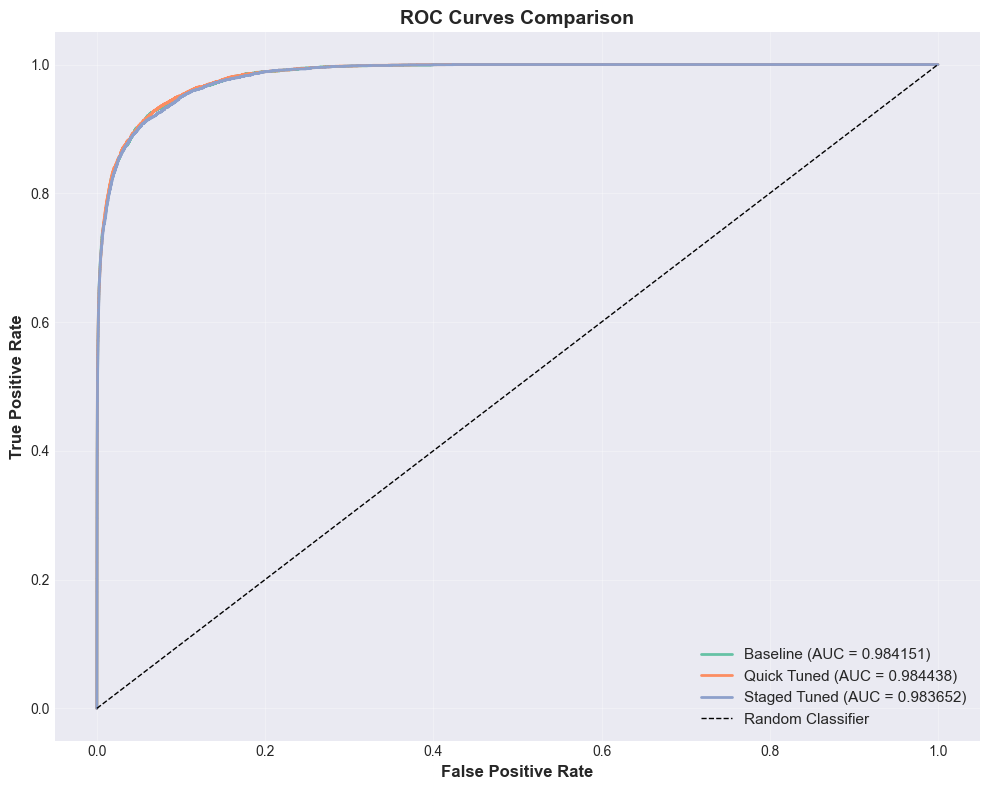

In [20]:
# Compare ROC curves
from sklearn.metrics import roc_curve, auc

baseline_pred = baseline_model.predict(X_val)
quick_pred = quick_tuned_model.predict(X_val)
staged_pred = staged_tuned_model.predict(X_val)

fig, ax = plt.subplots(figsize=(10, 8))

# Baseline
fpr_base, tpr_base, _ = roc_curve(y_val, baseline_pred)
roc_auc_base = auc(fpr_base, tpr_base)
ax.plot(fpr_base, tpr_base, linewidth=2, label=f'Baseline (AUC = {roc_auc_base:.6f})')

# Quick tuned
fpr_quick, tpr_quick, _ = roc_curve(y_val, quick_pred)
roc_auc_quick = auc(fpr_quick, tpr_quick)
ax.plot(fpr_quick, tpr_quick, linewidth=2, label=f'Quick Tuned (AUC = {roc_auc_quick:.6f})')

# Staged tuned
fpr_staged, tpr_staged, _ = roc_curve(y_val, staged_pred)
roc_auc_staged = auc(fpr_staged, tpr_staged)
ax.plot(fpr_staged, tpr_staged, linewidth=2, label=f'Staged Tuned (AUC = {roc_auc_staged:.6f})')

# Diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Summary

In [21]:
print("="*70)
print("MILESTONE 11: HYPERPARAMETER TUNING - COMPLETE")
print("="*70)

print("\n🎯 TUNING RESULTS:")
print(f"  • Baseline (default params):         {baseline_auc:.6f}")
print(f"  • Quick tuning (50 trials):          {quick_tuned_auc:.6f}  (+{(quick_tuned_auc - baseline_auc):.6f})")
print(f"  • Staged tuning (90 trials):         {staged_tuned_auc:.6f}  (+{(staged_tuned_auc - baseline_auc):.6f})")
print(f"  • Best improvement:                  +{max(quick_tuned_auc - baseline_auc, staged_tuned_auc - baseline_auc):.6f}")

print("\n📊 TUNING APPROACH:")
print("  • Method: Optuna (Tree-structured Parzen Estimator)")
print("  • Parameters tuned: 8 (learning_rate, num_leaves, max_depth, min_child_samples,")
print("                         subsample, colsample_bytree, reg_alpha, reg_lambda)")
print("  • Quick tuning: 50 trials (~20-30 min)")
print("  • Staged tuning: 90 trials in 3 stages (~30-45 min)")

print("\n🔧 KEY PARAMETER CHANGES:")
best_params = staged_complete_params if staged_tuned_auc > quick_tuned_auc else quick_complete_params
print(f"  • Learning rate:    {baseline_params['learning_rate']:.6f} → {best_params['learning_rate']:.6f}")
print(f"  • Num leaves:       {baseline_params['num_leaves']} → {best_params['num_leaves']}")
print(f"  • Max depth:        {baseline_params['max_depth']} → {best_params['max_depth']}")
print(f"  • Subsample:        {baseline_params['subsample']:.4f} → {best_params['subsample']:.4f}")

print("\n🎯 PROGRESS TO TARGET:")
best_auc = max(quick_tuned_auc, staged_tuned_auc)
print(f"  • Current AUC:                       {best_auc:.6f}")
print(f"  • Target (Top 10%):                  0.945000")
print(f"  • Gap remaining:                     {(0.945 - best_auc):.6f}")
print(f"  • Improvement from M10:              +{(best_auc - baseline_auc):.6f}")

print("\n✅ MILESTONE 11 COMPLETE")

print("\n🚀 NEXT STEPS (Milestones 12-13):")
print("  • M12: Feature selection (remove redundant/low-importance features)")
print("  • M13: Advanced modeling (stacking, blending, ensembles)")
print("  • Continue optimizing to reach 0.945+ (Top 10%)")

print("\n" + "="*70)
print("✓ HYPERPARAMETER TUNING COMPLETE")
print("="*70)

MILESTONE 11: HYPERPARAMETER TUNING - COMPLETE

🎯 TUNING RESULTS:
  • Baseline (default params):         0.984151
  • Quick tuning (50 trials):          0.984438  (+0.000286)
  • Staged tuning (90 trials):         0.983652  (+-0.000499)
  • Best improvement:                  +0.000286

📊 TUNING APPROACH:
  • Method: Optuna (Tree-structured Parzen Estimator)
  • Parameters tuned: 8 (learning_rate, num_leaves, max_depth, min_child_samples,
                         subsample, colsample_bytree, reg_alpha, reg_lambda)
  • Quick tuning: 50 trials (~20-30 min)
  • Staged tuning: 90 trials in 3 stages (~30-45 min)

🔧 KEY PARAMETER CHANGES:
  • Learning rate:    0.010000 → 0.010466
  • Num leaves:       256 → 274
  • Max depth:        12 → 15
  • Subsample:        0.9000 → 0.9407

🎯 PROGRESS TO TARGET:
  • Current AUC:                       0.984438
  • Target (Top 10%):                  0.945000
  • Gap remaining:                     -0.039438
  • Improvement from M10:              +0.000286

